In [1]:
!pip -q install mrjob pandas matplotlib

In [2]:
import pandas as pd

In [3]:
%%file wordcount.py
# %%file is an Ipython magic function that saves the code cell as a file
import sys
from mrjob.job import MRJob, MRStep


class MRWordCount(MRJob):
    def mapper(self, _, line):
        # чистим от всякого мусора, и порядковых номеров
        words = (line.lower())\
        .replace("(", '').replace(")", '').replace("!", '')\
        .replace(".", '').replace(",", '').replace("'", '')\
        .replace("?", '').replace('"', '').split()[1:]
        person = words[0] # берем только первое слово, то есть имя персонажа
        yield (person, 1)

    def reducer(self, persons, values):
        yield (persons, sum(values))

    def mapper_top20(self, persons, count):
        yield (None, (count, persons))

    def reducer_top20(self, _, count_person_pairs):
        top20 = sorted(count_person_pairs, reverse=True)[:20]
        for count, persons in top20:
            yield (persons, count)

    def steps(self):
        return [
            MRStep(mapper=self.mapper, reducer=self.reducer),
            MRStep(mapper=self.mapper_top20, reducer=self.reducer_top20)
        ]
        
if __name__ == "__main__":
    MRWordCount.run()

Overwriting wordcount.py


In [4]:
!python3 wordcount.py SW_EpisodeIV.txt > out1.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/wordcount.root.20231129.124932.293293
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/wordcount.root.20231129.124932.293293/output
Streaming final output from /tmp/wordcount.root.20231129.124932.293293/output...
Removing temp directory /tmp/wordcount.root.20231129.124932.293293...


In [5]:
!python3 wordcount.py SW_EpisodeV.txt > out2.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/wordcount.root.20231129.124932.854989
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/wordcount.root.20231129.124932.854989/output
Streaming final output from /tmp/wordcount.root.20231129.124932.854989/output...
Removing temp directory /tmp/wordcount.root.20231129.124932.854989...


In [6]:
!python3 wordcount.py SW_EpisodeVI.txt > out3.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/wordcount.root.20231129.124933.325119
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/wordcount.root.20231129.124933.325119/output
Streaming final output from /tmp/wordcount.root.20231129.124933.325119/output...
Removing temp directory /tmp/wordcount.root.20231129.124933.325119...


In [7]:
df1 = pd.read_csv('out1.csv', sep='\t', names=['name', 'count'], index_col=['name'])
df2 = pd.read_csv('out2.csv', sep='\t', names=['name', 'count'], index_col=['name'])
df3 = pd.read_csv('out3.csv', sep='\t', names=['name', 'count'], index_col=['name'])

Построим график первого файла

<Axes: xlabel='name'>

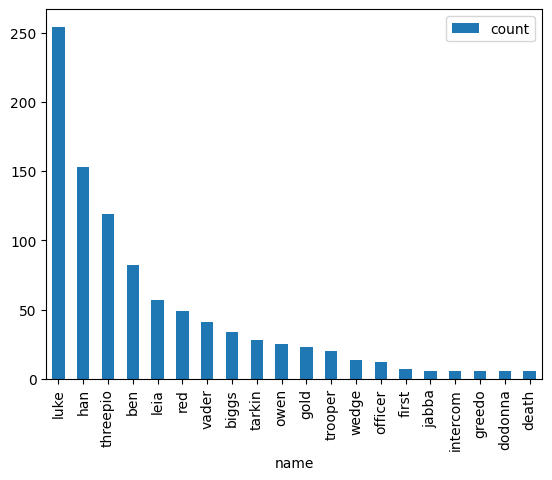

In [8]:
df1.plot(kind='bar')

<Axes: xlabel='name'>

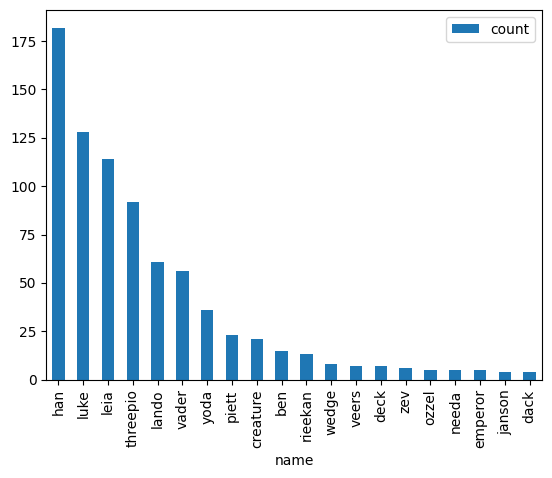

In [9]:
df2.plot(kind='bar')

<Axes: xlabel='name'>

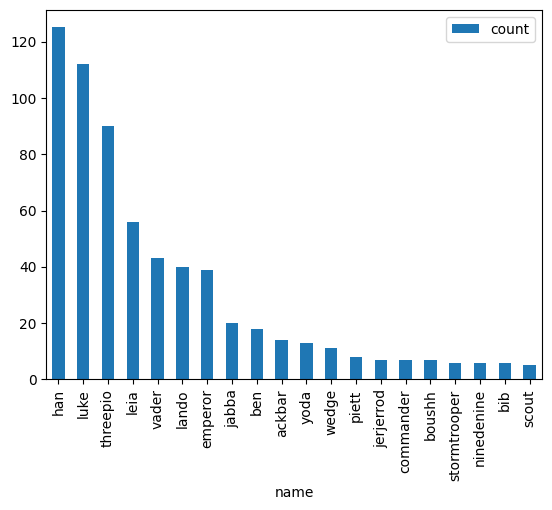

In [10]:
df3.plot(kind='bar')

Объединим три датафрейма и выведем итоговые значения

<Axes: xlabel='name'>

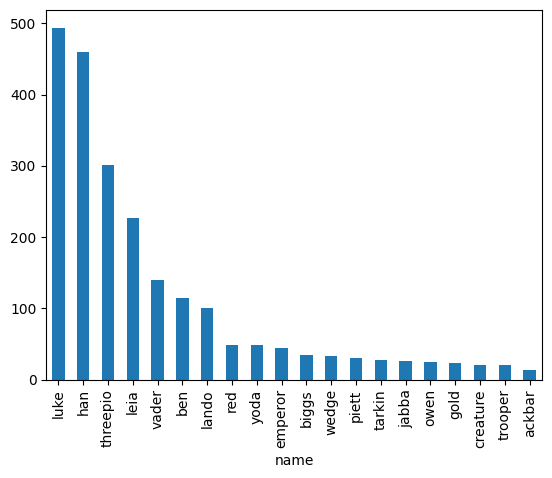

In [11]:
concatenated_df = pd.concat([df1, df2, df3])
result_df = concatenated_df.groupby(concatenated_df.index)['count'].sum()
result_df.sort_values(ascending=False)[:20].plot(kind='bar')

---
Теперь посчитаем на кластере, для примера посчитаем только первый файл

In [12]:
!hdfs dfsadmin -safemode leave #Почему то нода в безопасном режиме была, выключим этот режим

Safe mode is OFF


In [13]:
!hadoop fs -put SW_EpisodeIV.txt /hw1

put: `/hw1/SW_EpisodeIV.txt': File exists


In [14]:
!hadoop fs -put SW_EpisodeV.txt /hw1

put: `/hw1/SW_EpisodeV.txt': File exists


In [15]:
!hadoop fs -put SW_EpisodeVI.txt /hw1

put: `/hw1/SW_EpisodeVI.txt': File exists


In [16]:
%%file config.conf

runners:
  hadoop: # also works for emr runner
    jobconf:
      mapreduce.job.reduces: 2

Overwriting config.conf


In [17]:
!python3 wordcount.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeIV.txt --conf-path config.conf --output /hw1/output11

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/wordcount.root.20231129.124949.113959
uploading working dir files to hdfs:///user/root/tmp/mrjob/wordcount.root.20231129.124949.113959/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/wordcount.root.20231129.124949.113959/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar6710193501781058379/] [] /tmp/streamjob8052013353125413679.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0023
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1700575

In [18]:
!hadoop fs -cat /hw1/output11/part-00000

"luke"	254
"han"	153
"threepio"	119
"ben"	82
"leia"	57
"red"	49
"vader"	41
"biggs"	34
"tarkin"	28
"owen"	25
"gold"	23
"trooper"	20
"wedge"	14
"officer"	12
"first"	7
"jabba"	6
"intercom"	6
"greedo"	6
"dodonna"	6
"death"	6


In [19]:
!python3 wordcount.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeV.txt --conf-path config.conf --output /hw1/output12

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/wordcount.root.20231129.125057.984584
uploading working dir files to hdfs:///user/root/tmp/mrjob/wordcount.root.20231129.125057.984584/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/wordcount.root.20231129.125057.984584/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar2822239909934371425/] [] /tmp/streamjob7982154965134172621.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0024
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1700575

In [20]:
!hadoop fs -cat /hw1/output12/part-00000

"han"	182
"luke"	128
"leia"	114
"threepio"	92
"lando"	61
"vader"	56
"yoda"	36
"piett"	23
"creature"	21
"ben"	15
"rieekan"	13
"wedge"	8
"veers"	7
"deck"	7
"zev"	6
"ozzel"	5
"needa"	5
"emperor"	5
"janson"	4
"dack"	4


In [21]:
!python3 wordcount.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeVI.txt --conf-path config.conf --output /hw1/output13

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/wordcount.root.20231129.125203.475470
uploading working dir files to hdfs:///user/root/tmp/mrjob/wordcount.root.20231129.125203.475470/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/wordcount.root.20231129.125203.475470/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar8916187559392469455/] [] /tmp/streamjob8342252609008997655.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0025
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1700575

In [22]:
!hadoop fs -cat /hw1/output13/part-00000

"han"	125
"luke"	112
"threepio"	90
"leia"	56
"vader"	43
"lando"	40
"emperor"	39
"jabba"	20
"ben"	18
"ackbar"	14
"yoda"	13
"wedge"	11
"piett"	8
"jerjerrod"	7
"commander"	7
"boushh"	7
"stormtrooper"	6
"ninedenine"	6
"bib"	6
"scout"	5
